A silly project using a simulated quantum circuit (with IBM's Qiskit) to generate random numbers from a provided range.

Obviously not intended to be practically useful, rather an example for practicing basic operations in Qiskit:

* Circuit creation
* Circuit visualization
* Statevector visualization

Uses the [Fast Dice Roller](https://arxiv.org/abs/1304.1916) algorithm 

Side note about RNG based on a source of entropy in the form of random bits:

It turns out that generating numbers from a discrete uniform distribution based on random bits is a more complicated problem than I used to think! As an analogy: by rolling a d20 you can get a number in a range 1-10 easily by assuming that, for example, faces 1-2 correspond to "1", 3-4 correspond to "2" etc., but you cannot as easily get numbers in the range 1-12 from a d20 because the number of faces does not allow a uniform mapping. The same principle applies here.


In [1]:
import numpy as np

In [2]:
#Install Qiskit and aer
!pip install qiskit
!pip install qiskit-aer

  Obtaining dependency information for qiskit from https://files.pythonhosted.org/packages/53/94/a6e81b62222cdeaa4bed854e39983afa1b52da6156d764d7b3e87b4a6791/qiskit-0.45.2-py3-none-any.whl.metadata
  Obtaining dependency information for qiskit-terra==0.45.2 from https://files.pythonhosted.org/packages/da/ab/598e92af609f0ec26f43859e485b15318930ae5d0782420c8e53119e57a5/qiskit_terra-0.45.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for rustworkx>=0.13.0 from https://files.pythonhosted.org/packages/16/05/bcbfcb9c87c9b2c33fcb2d715f4f8de21ea1b870b148f98ba5c2c1cfc79f/rustworkx-0.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.4 MB/s eta 0:00:00
  Obtaining dependency information for stevedore>=3.0.0 from https://files.pythonhosted.org/packages/4b/68/e739fd061b0aba464bef8e8be48428b2aabbfb3f2f8f2f8ca257363ee6b2/stevedore-5.1.0-py3-none-any.whl.metadata


In [3]:
#Imports
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram

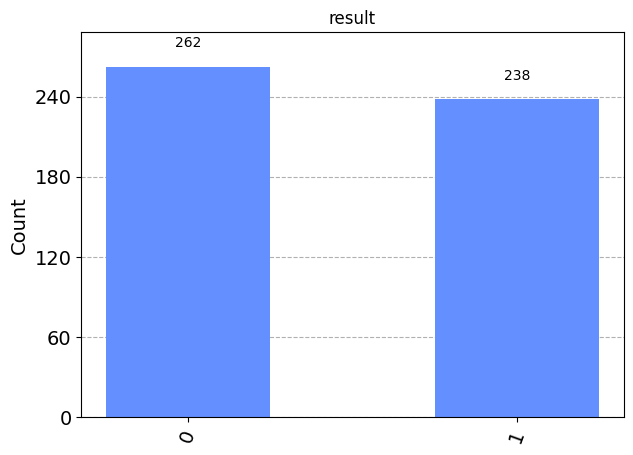

In [4]:
# Construct quantum circuit
circ = QuantumCircuit(1,1)
circ.h(0)
circ.measure(0,0)

# Select the QasmSimulator from the Aer provider
# If we wanted to use IBM Cloud we'd need to set up a service with our own token here
# https://docs.quantum.ibm.com/start/setup-channel
simulator = Aer.get_backend('qasm_simulator')

# Execute and get counts
result = execute(circ, simulator, shots=500).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='result')

In [5]:
#Draw the circuit
circ.draw()

┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0

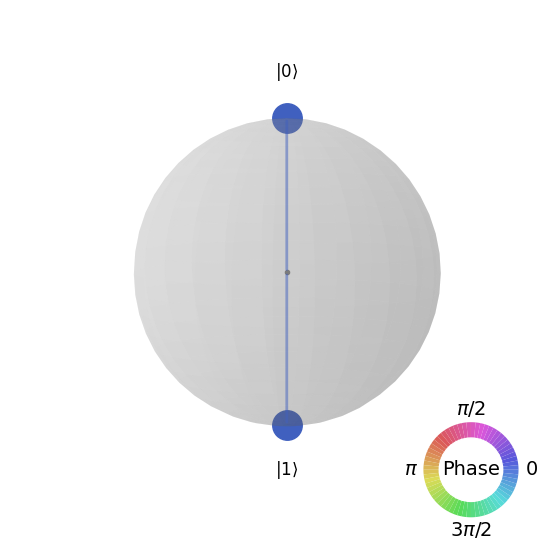

In [6]:
#Draw the result state-vector before measurement
from qiskit.tools.visualization import plot_state_qsphere
circ2 = QuantumCircuit(1,1)
circ2.h(0)

result2 = execute(circ2, Aer.get_backend('statevector_simulator') , shots=1).result()
psi  = result2.get_statevector(circ2)
plot_state_qsphere(psi)

In [7]:
#Function for getting a random bit

def get_random_bit():
    job = execute(circ, simulator, shots=1, memory=True)
    result = job.result().get_memory()[0]
    return int(result)

get_random_bit()

1

In [8]:
#Fast dice roller
#https://arxiv.org/abs/1304.1916
#Range from 0 to n-1
def fast_dice_roller(n):
    v=1
    c=0
    while(True):
        v*=2
        c*=2
        c+=get_random_bit()
        if(v>=n):
            if(c<n):
                return c
            else:
                v-=n
                c-=n

def custom_rand(start_inclusive, end_exclusive):
    rand_range = end_exclusive-start_inclusive
    return(fast_dice_roller(rand_range)+start_inclusive)

Note: the above algorithm could likely run much faster if we generated lots of bits by calling the .execute() function on the quantum circuit once with many shots to get a large array of random bits, and then calling it again if we run out during generation. (.execute() appears to be optimized for multiple shots)

(array([1330., 1375., 1357., 1378., 1376., 1376.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <BarContainer object of 6 artists>)

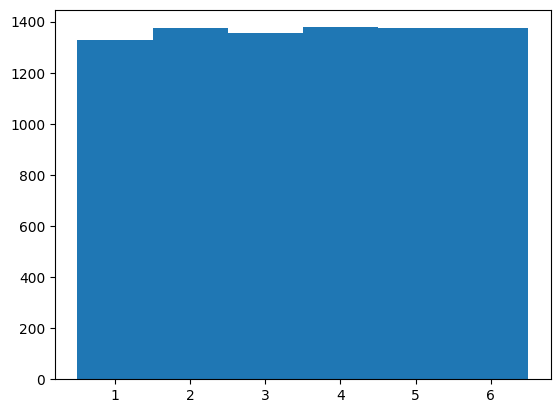

In [9]:
#Roll a d6
roll_start=1
roll_end=6

from matplotlib import pyplot as plt
roll_results = [custom_rand(roll_start,roll_end+1) for i in range(8192)]
bins = np.arange(1, roll_end + 1.5) - 0.5 #Align the bins so the histogram looks nicer for discrete values
plt.hist(roll_results,bins)